In [6]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy.io as sio
from functools import partial
from generic_pose.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12

In [2]:
from dense_fusion.evaluate import DenseFusionEstimator
from dense_fusion.evaluate_likelihood import evaluateYCBDataset, getYCBClassData
from dense_fusion.evaluate_likelihood import evaluateYCBMax, evaluateYCBEvery


num_points = 1000
num_obj = 21

dataset_root = './datasets/ycb/YCB_Video_Dataset'
valid_model_checkpoint = '../DenseFusionOld/DenseFusion/trained_models/ycb/pose_model_34_0.025648579025031315.pth'

dataset_config_dir = 'datasets/ycb/dataset_config'
file_list = '{0}/test_data_list.txt'.format(dataset_config_dir)

estimator = DenseFusionEstimator(num_points, num_obj, valid_model_checkpoint)
classes = getYCBClassData(dataset_root)[0]

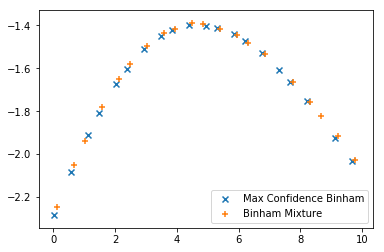

In [3]:
#data_max = np.load('results/single_max_sigmas.npz')
data_max = np.load('single_max_sigmas.npz')
mean_likelihoods_max = data_max['mean_likelihoods']
sigmas_max = data_max['sigmas']

#data_every = np.load('results/bingham_every_sigmas.npz')
data_every = np.load('bingham_every_sigmas.npz')
mean_likelihoods_every = data_every['mean_likelihoods']
sigmas_every = data_every['sigmas']

plt.scatter(sigmas_max, mean_likelihoods_max,
            marker='x', label='Max Confidence Binham')
plt.scatter(sigmas_every, mean_likelihoods_every,
            marker='+', label='Binham Mixture')
plt.legend()
plt.show()

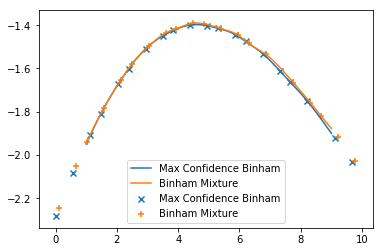

4.607214428857715
4.591182364729459


In [4]:
from scipy.interpolate import interp1d

ll_max = interp1d(sigmas_max, mean_likelihoods_max, kind='cubic')

sigmas_every_fin = sigmas_every[np.bitwise_not(np.isinf(mean_likelihoods_every))]
mean_likelihoods_every_fin = mean_likelihoods_every[np.bitwise_not(np.isinf(mean_likelihoods_every))]
ll_every = interp1d(sigmas_every_fin, mean_likelihoods_every_fin, kind='cubic')
sigmas = np.linspace(1,9,500)
plt.plot(sigmas, ll_max(sigmas), label='Max Confidence Binham')
plt.plot(sigmas, ll_every(sigmas), label='Binham Mixture')

mask_max = sigmas_max < 10
mask_every = sigmas_every < 10
plt.scatter(sigmas_max[mask_max], mean_likelihoods_max[mask_max],
            marker='x', label='Max Confidence Binham')
plt.scatter(sigmas_every[mask_every], mean_likelihoods_every[mask_every],
            marker='+', label='Binham Mixture')

plt.legend()
plt.show()
print(sigmas[np.argmax(ll_max(sigmas))])
print(sigmas[np.argmax(ll_every(sigmas))])


In [2]:
data_max = np.load('single_max_4.395888621129805.npz')
likelihoods_max = data_max['likelihoods'].tolist()
sigma_max = data_max['sigma']
data_every = np.load('bing_every_4.324736029040155.npz')
likelihoods_every = data_every['likelihoods'].tolist()
sigma_every = data_every['sigma']

In [35]:
from functools import partial


eval_func = partial(evaluateYCBEvery, estimator, sigma=sigma_every, return_exponent=True)
v = eval_func('{}/{}'.format(dataset_root, file_list[0]))
l_exp, w = v[1]
print(to_np(logSumExp(l_exp, w, binghamNormC(sigma_every))))
eval_func = partial(evaluateYCBEvery, estimator, sigma=sigma_every, return_exponent=False)
v = eval_func('{}/{}'.format(dataset_root, file_list[0]))


[-0.7070009]
[-0.685212]


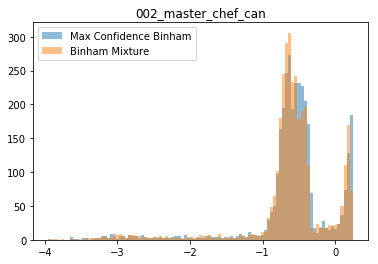

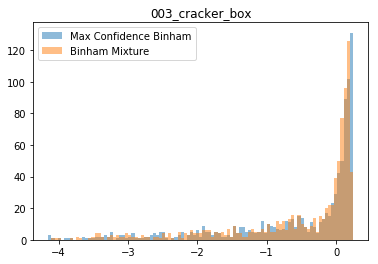

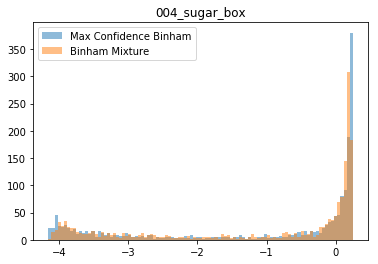

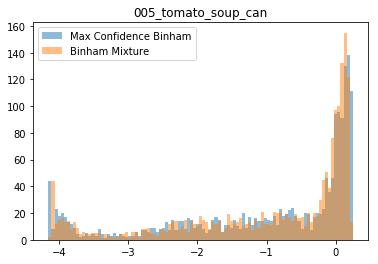

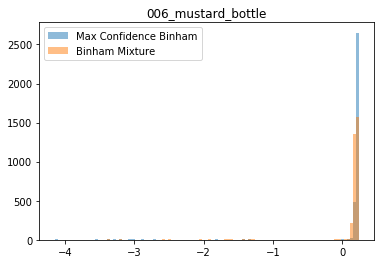

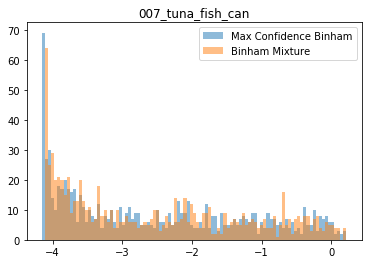

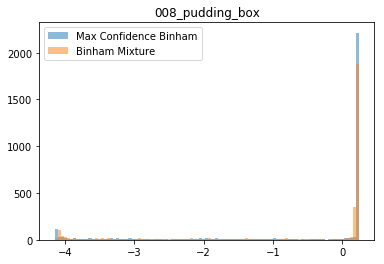

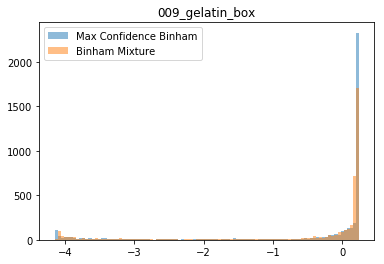

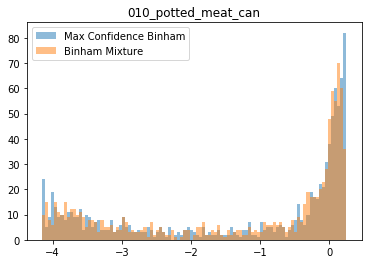

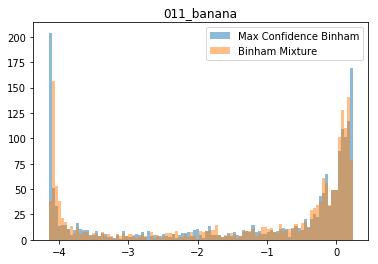

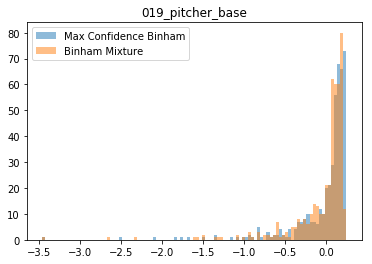

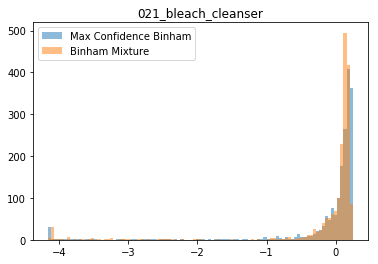

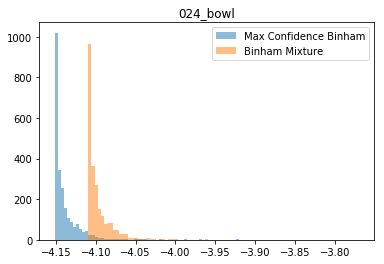

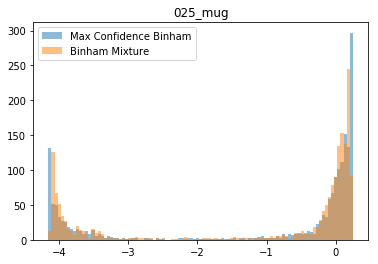

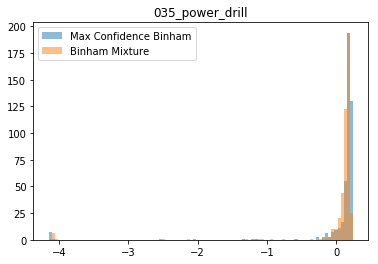

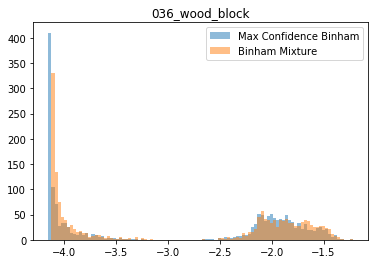

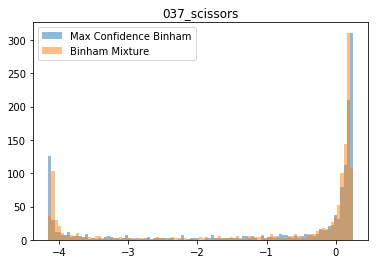

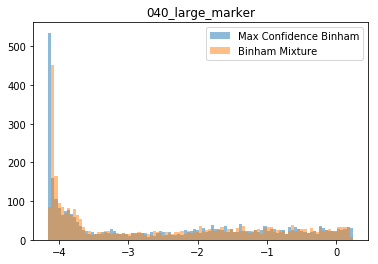

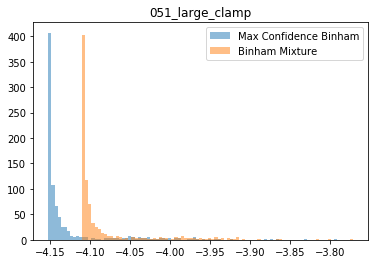

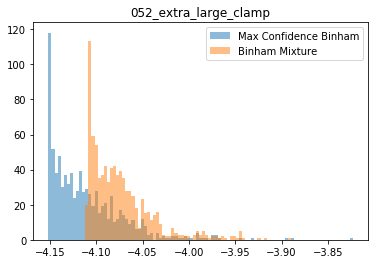

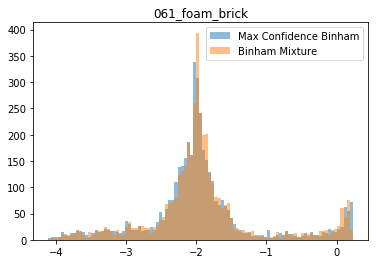

In [37]:
for k in likelihoods_max.keys():
    ll_max, _ = zip(*likelihoods_max[k])
    ll_max = np.log(to_np(torch.stack(ll_max)))
    ll_every, _ = zip(*likelihoods_every[k])
    ll_every = np.log(to_np(torch.stack(ll_every)))

    bins = np.linspace(min(ll_max.min(), ll_every.min()), 
                       max(ll_max.max(), ll_every.max()), 100)

    plt.hist(ll_max, bins, alpha=0.5, label='Max Confidence Binham')
    plt.hist(ll_every, bins, alpha=0.5, label='Binham Mixture')
    plt.title(classes[k-1])
    plt.legend()
    plt.show()

In [ ]:
print(max(ll_max))
print(max(ll_every))

In [ ]:
from object_pose_utils.utils.interpolation import BinghamInterpolation
from object_pose_utils.utils import to_np

sigma_max = data_max['sigma']
sigma_every = data_every['sigma']


q_center = np.array([1,0,0,0])
q_wrong = np.array([0,1,0,0])

w = [1]

bingham_max = BinghamInterpolation(vertices = [q_center], 
                                      values = torch.Tensor(w), 
                                      sigma=sigma_max)

bingham_every = BinghamInterpolation(vertices = [q_center], 
                                      values = torch.Tensor(w), 
                                      sigma=sigma_every)

max_p_max = to_np(bingham_max(torch.Tensor(q_center).unsqueeze(0).cuda()))[0]
min_p_max = to_np(bingham_max(torch.Tensor(q_wrong).unsqueeze(0).cuda()))[0]
max_p_every = to_np(bingham_every(torch.Tensor(q_center).unsqueeze(0).cuda()))[0]
min_p_every = to_np(bingham_every(torch.Tensor(q_wrong).unsqueeze(0).cuda()))[0]

print('Max Confidence Binham: [{}, {}]'.format(np.log(min_p_max), np.log(max_p_max)))
print('Binham Mixture: [{}, {}]'.format(np.log(min_p_every), np.log(max_p_every)))


In [9]:
ll_max, _ = zip(*likelihoods_max[1])
ll_max = np.log(to_np(torch.stack(ll_max)))
np.mean(ll_max)

-0.5833238